In [33]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [34]:
datasets_names = {
    "customers" : "olist_customers_dataset.csv",
    "geolocation" : "olist_geolocation_dataset.csv",
    "order_items" : "olist_order_items_dataset.csv",
    "order_payments" : "olist_order_payments_dataset.csv",
    "order_reviews" : "olist_order_reviews_dataset.csv",
    "orders" : "olist_orders_dataset.csv",
    "products" : "olist_products_dataset.csv",
    "sellers" : "olist_sellers_dataset.csv",
    "category_name_translation" : "product_category_name_translation.csv"
}

## Formatting data

In [35]:
# Lê os datasets
order_items_df = pd.read_csv(datasets_names["order_items"])
orders_df = pd.read_csv(datasets_names["orders"])
customers_df = pd.read_csv(datasets_names["customers"])
products_df = pd.read_csv(datasets_names["products"])
order_payments_df = pd.read_csv(datasets_names["order_payments"])
sellers_df = pd.read_csv(datasets_names["sellers"])
geolocation_df = pd.read_csv(datasets_names["geolocation"])

# Remove os outliers
order_items_df = order_items_df[order_items_df["freight_value"] < 50]
order_items_df = order_items_df[order_items_df["price"] < 270]

# Agrupa as informações
result_df = order_items_df.merge(orders_df, on='order_id') \
                    .merge(order_payments_df, on=['order_id']) \
                    .merge(products_df, on='product_id') \
                    .merge(customers_df, on='customer_id') \
                    .merge(sellers_df, on='seller_id')

# Remove os items que possuam valores nulos
result_df = result_df.dropna()

result_df = result_df[['price', 'freight_value', 'product_weight_g', 'product_height_cm', 'product_width_cm', 'product_length_cm', 'customer_zip_code_prefix', 'seller_zip_code_prefix']]


# Remove os valores duplicados
geolocation_unique = geolocation_df.drop_duplicates('geolocation_zip_code_prefix')

# Cria um mapa para a lat e long de acordo com zipcode
geolocation_mapping = geolocation_unique.set_index('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng', 'geolocation_city']].to_dict(orient='index')

# Cria as colunas lat, lng, e city dos clientes a partir do mapa
result_df['customer_lat'] = result_df['customer_zip_code_prefix'].map(lambda x: geolocation_mapping[x]['geolocation_lat'] if x in geolocation_mapping else None)
result_df['customer_lng'] = result_df['customer_zip_code_prefix'].map(lambda x: geolocation_mapping[x]['geolocation_lng'] if x in geolocation_mapping else None)
result_df['customer_city'] = result_df['customer_zip_code_prefix'].map(lambda x: geolocation_mapping[x]['geolocation_city'] if x in geolocation_mapping else None)

# Cria as colunas lat, lng, e city dos vendedores a partir do mapa
result_df['seller_lat'] = result_df['seller_zip_code_prefix'].map(lambda x: geolocation_mapping[x]['geolocation_lat'] if x in geolocation_mapping else None)
result_df['seller_lng'] = result_df['seller_zip_code_prefix'].map(lambda x: geolocation_mapping[x]['geolocation_lng'] if x in geolocation_mapping else None)
result_df['seller_city'] = result_df['seller_zip_code_prefix'].map(lambda x: geolocation_mapping[x]['geolocation_city'] if x in geolocation_mapping else None)

# Remove as colunas 'customer_zip_code_prefix' e 'seller_zip_code_prefix'
result_df.drop(['customer_zip_code_prefix', 'seller_zip_code_prefix', 'customer_city', 'seller_city'], axis=1, inplace=True)

result_df = result_df.dropna()
display(result_df)


,price,freight_value,product_weight_g,product_height_cm,product_width_cm,product_length_cm,customer_lat,customer_lng,seller_lat,seller_lng
0,58.9,13.29,650.0,9.0,14.0,28.0,-21.758076,-41.312633,-22.498183,-44.123614
1,55.9,17.96,650.0,9.0,14.0,28.0,-17.885607,-51.719640,-22.498183,-44.123614
2,64.9,18.33,650.0,9.0,14.0,28.0,-19.918025,-43.976133,-22.498183,-44.123614
3,58.9,16.17,650.0,9.0,14.0,28.0,-25.516321,-49.122818,-22.498183,-44.123614
4,58.9,13.29,650.0,9.0,14.0,28.0,-20.653542,-43.790837,-22.498183,-44.123614
...,...,...,...,...,...,...,...,...,...,...
105554,27.9,14.44,2000.0,38.0,19.0,19.0,-23.098284,-45.703308,-23.567864,-46.592424
105555,27.9,14.44,2000.0,38.0,19.0,19.0,-23.098284,-45.703308,-23.567864,-46.592424
105556,119.9,44.45,8850.0,7.0,90.0,74.0,-23.589152,-46.550834,-20.889601,-49.571657
105557,82.8,14.89,1000.0,6.0,40.0,70.0,-22.210461,-49.935713,-21.766477,-48.831547


In [36]:
# Determina quais colunas representarão o input e quais representarão o output
x = result_df.drop(["freight_value"],axis=1).values
y = result_df["freight_value"].values

In [37]:
# Separa os dados
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 137)

In [38]:
# Normaliza o input
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [39]:
# Converte as listas em tensores
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

## Neural network

In [40]:
# Modelo de rede neural
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self, input_dim : int, output_dim : int, middle_layers_dim : list[int] = []):
        super(NeuralNetworkClassificationModel,self).__init__()

        # Salva as camadas iniciais
        layers_dim = [input_dim, *middle_layers_dim]
        self.layers = []
        for i in range(len(layers_dim)-1):
            self.layers.append(nn.Linear(layers_dim[i],layers_dim[i+1]))
        self.layers = nn.ModuleList(self.layers)

        # Camada final
        self.output_layer = nn.Linear(layers_dim[-1], output_dim)

        self.elu = nn.ELU()

    def forward(self, x):
        for layer in self.layers:
            x = self.elu(layer(x))
        x = self.elu(self.output_layer(x))
        return x

In [41]:
# Cria o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetworkClassificationModel(9, 1, [15, 20, 20, 32, 40, 40, 32, 32, 20, 20])
model = model.to(device)

In [42]:
learning_rate = 0.035
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [43]:
from tqdm.notebook import trange
def train_network(model,optimizer,criterion,x_train,y_train,x_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in trange(num_epochs):
        model.train()

        # Limpa o gradiente da última iteração
        optimizer.zero_grad()

        # Calcula os valores de saída para os dados de treinamento
        output_train = model(x_train)

        # Calcula a taxa de erro dos dados de treinamento
        loss_train = criterion(output_train, y_train)

        # Calcula os gradientes
        loss_train.backward()

        # Atualiza os pesos
        optimizer.step()

        # Calculas os valores para os dados de teste
        output_test = model(x_test)
        loss_test = criterion(output_test,y_test)

        # Imprime os valores da últime iteração
        if(epoch == num_epochs - 1):
            print(y_test.tolist())
            print(output_test.tolist())

        # Salva as taxas de erro
        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

In [44]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

In [45]:
train_network(model,optimizer,criterion,x_train,y_train,x_test,y_test,num_epochs,train_losses,test_losses)

  0%|          | 0/1000 [00:00<?, ?it/s]

[[19.65999984741211], [21.760000228881836], [26.3799991607666], [14.520000457763672], [16.110000610351562], [11.829999923706055], [12.449999809265137], [7.78000020980835], [15.180000305175781], [15.4399995803833], [45.09000015258789], [18.239999771118164], [7.389999866485596], [14.100000381469727], [15.100000381469727], [9.34000015258789], [25.3799991607666], [7.389999866485596], [19.149999618530273], [17.530000686645508], [17.979999542236328], [11.359999656677246], [16.110000610351562], [7.78000020980835], [19.31999969482422], [16.790000915527344], [19.59000015258789], [13.569999694824219], [32.84000015258789], [22.059999465942383], [11.350000381469727], [19.25], [15.350000381469727], [43.189998626708984], [48.279998779296875], [23.959999084472656], [23.969999313354492], [9.34000015258789], [14.100000381469727], [7.619999885559082], [14.369999885559082], [9.9399995803833], [16.829999923706055], [39.470001220703125], [16.049999237060547], [20.190000534057617], [14.720000267028809], [18

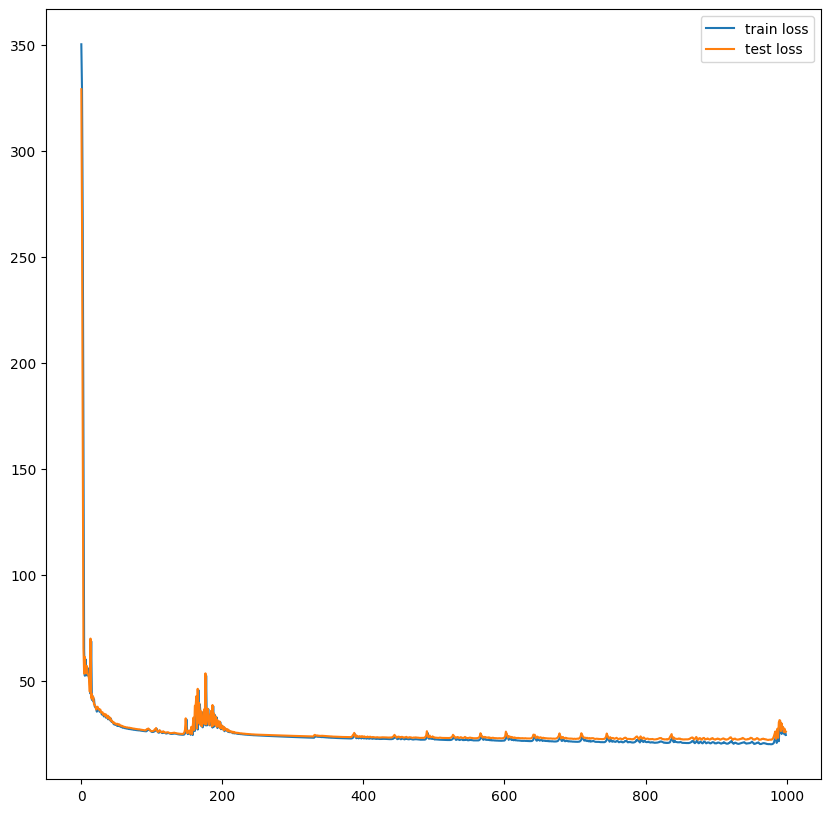

In [46]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

(0.0, 50.0)

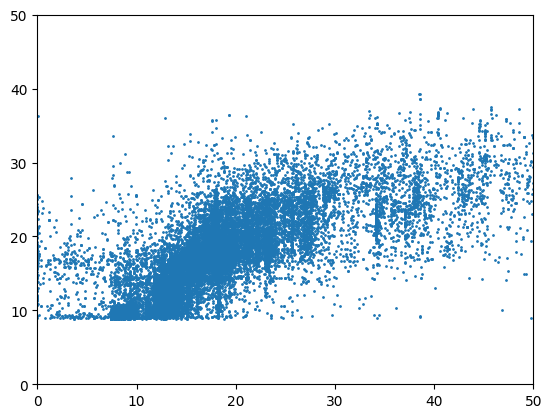

In [47]:
#Predição dos pontos com os dados de teste
y_pred = model(x_test).tolist()
plt.scatter(y_test, y_pred, s=1)
plt.xlim(0, 50)
plt.ylim(0, 50)

(0.0, 50.0)

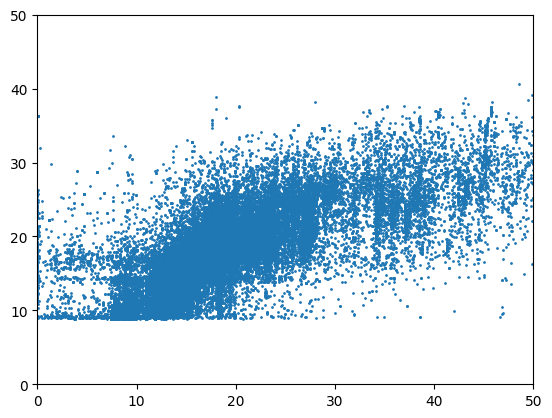

In [48]:
#Predição dos pontos com os dados de teste
y_pred = model(x_train).tolist()
plt.scatter(y_train, y_pred, s=1)
plt.xlim(0, 50)
plt.ylim(0, 50)